In [43]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph LR;
    A["True Sky I(l,m)"] --> B["Degridding"];
    D["Interferometer Config"] --> B["Degridding"];
    B --> C["Visibility V(u,v,w)"];
""")


# Generating visibilities from custom true sky image

This notebook aim to generate visibilities from custom "true" sky image with the standard dataflow degridding method.


## std_degridding() principle
Degridding is a key stage in the imaging process, where the values of a regular grid are interpolated to irregular points (the visibilities).

#### 🔎 The std_degridding consist in:
- Take an `input_grid` containing the transformed data.
- Extract (interpolate) the values at specific positions defined by the `corrected_vis_uvw_coords`.
- Apply a correction via an interpolation `kernel`.
- Store the result in `output_visibilities`.


#### 🧱 Function parameters:

```c
void std_degridding(
 int GRID_SIZE, // Grid size (GRID_SIZE x GRID_SIZE)
 int NUM_VISIBILITIES, // Total number of visibilities to process
 //int NUM_KERNELS, // Total number of kernels available
 //int TOTAL_KERNEL_SAMPLES,          // Total number of samples in the kernels array
 int OVERSAMPLING_FACTOR, // Oversampling factor for fine interpolation
 PRECISION2* kernels, // Array containing kernel samples
 int2* kernel_supports,             // Table containing the kernel supports
 PRECISION2* input_grid, // Table containing the input grid
 PRECISION3* corrected_vis_uvw_coords, // Table containing the corrected UVW coordinates
 int* num_corrected_visibilities, // Number of corrected visibilities to process
 Config* config, // Global configuration (UV and W scales)
 PRECISION2* output_visibilities // Output table containing the extracted visibilities
)
```

#### Complexity O(n):

Degridding can be time-consuming depending on certain parameters, which are worth revealing.
The complexity of this calculation is dominated by three nested loops:

$O(n_v . n_{\mathcal{D}}²)$, where:

- $n_v$ is the number of corrected visibilities (or `*num_corrected_visibilities`),
- $n_{\mathcal{D}}$ is a measure of the size of the kernel (or more precisely half the size of the kernel support on each axis).

This means that the complexity of the calculation increases quadratically with the size of the kernel support and linearly with the number of corrected visibilities.

To better understand the complexity of the calculation, we need to configure its inputs and analyze the output.

# Notebook steps:

1. Generer un image avec pour parametre: `GRID_SIZE`, `NUM_SOURCE`.
2. Exporter au format *.csv pour faciliter la lecture en C.
3. Generer les noyaux de convolution avec pour parametre: `NUM_KERNEL`, `OVERSAMPLING_FACTOR`. 
4. Executer `./STD_DEGRID`.
5. Afficher les visibilités générées sur le plan $uv$.

*Before starting, here is an example of visibility from the GLEAM dataset (access [here](https://nasext-vaader.insa-rennes.fr/ietr-vaader/)). The GLEAM dataset provides low-frequency radio observations, which are useful for testing degridding accuracy.*

Min u : -30231.426923, Max u : 17860.497452
Min v : -22804.830289, Max v : 27478.047105
Min réel : -10.4285581666273, Max réel : 12.0908793522638
Min imaginaire : -11.6353456899264, Max imaginaire : 10.5571324792557
Maximum d'amplitude : 13.367794202018839


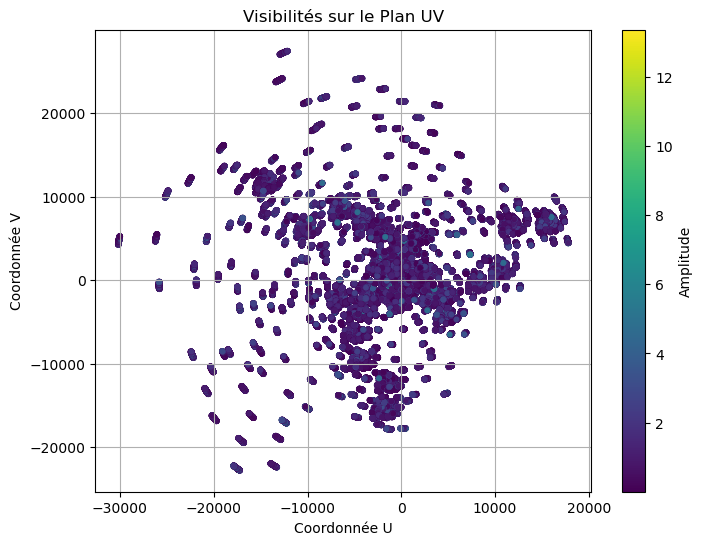

In [5]:
from plot_vis import plot_visibilities

plot_visibilities("../example/GLEAM_small_visibilities_corrupted.csv")

#### Step 1: run the custom script to generate a custom *.fits & Step 2: convert as csv

Fichier FITS généré : code/radioastro.fits


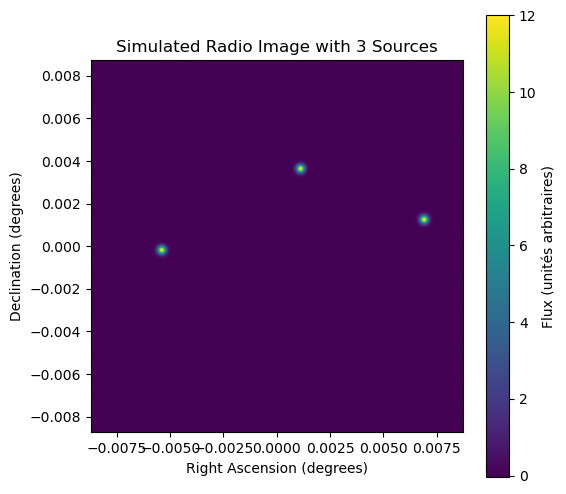

Fichier sauvegarder dans : code/image.csv


In [1]:
from fits_to_csv import generate_fits, generate_csv


GRID_SIZE = 512
NUM_SOURCES = 3

generate_fits(GRID_SIZE, NUM_SOURCES, "code/radioastro.fits")
generate_csv("code/radioastro.fits","code/image.csv")



#### Step 3: build degridding kernels

Dans les pipelines classique d'imagerie radio-interferometrique les kernels (ou noyaux) sont utilisé pour les convolutions sur les données. Les noyaux de gidding degridding sont des fonctions qui prennent en compte l'espacement des points de données et leur position relative sur la grille, et elles ajustent les valeurs des pixels de l'image pour correspondre aux signaux capturés par les antennes.

Ici, les noyaux sont utilisés pour simuler l'impact du réseau d'antennes sur l'image de sortie, en tenant compte de plusieurs facteurs comme :

1.    Projection spatiale : Le réseau interférométrique capte des signaux provenant de différentes positions dans l’espace. Les kernels sont utilisés pour projeter l'information contenue dans l'image (domaine spatial) sur les visibilités, en tenant compte des fréquences et des angles de vue des antennes.

2.    Transformation de Fourier : Les visibilités sont souvent obtenues par une transformation de Fourier des données, ce qui permet de passer du domaine spatial au domaine fréquentiel. Les kernels utilisés dans cette transformation permettent de modéliser comment les différentes fréquences (composantes de l'onde radio) sont captées par les antennes. Ces transformations sont souvent réalisées via des kernels de gridding, qui placent les données mesurées sur une grille régulière avant de les convertir en visibilités.

3.    Correction des distorsions : Les distorsions peuvent apparaître lors de la conversion des données spatiales vers les données fréquentielles. Les kernels sphéroïdaux ou d'autres types de filtres peuvent être utilisés pour éviter des artefacts comme le repliement des fréquences (aliasing) et garantir que les visibilités simulées sont réalistes.

cell_size_arcsec3.408846195301425e-05
Local max support = 4.768771169957166
w.shape = (5, 5)
Taille avant la FFT: (80, 80)
Taille après la FFT: (80, 80)
Taille après la FFT conjugate: (80, 80)
Taille après la iso conjugate: (48, 48)
w.shape = (5, 5)
Taille avant la FFT: (80, 80)
Taille après la FFT: (80, 80)
Taille après la FFT conjugate: (80, 80)
Taille après la iso conjugate: (48, 48)
w.shape = (5, 5)
Taille avant la FFT: (80, 80)
Taille après la FFT: (80, 80)
Taille après la FFT conjugate: (80, 80)
Taille après la iso conjugate: (48, 48)
w.shape = (5, 5)
Taille avant la FFT: (80, 80)
Taille après la FFT: (80, 80)
Taille après la FFT conjugate: (80, 80)
Taille après la iso conjugate: (48, 48)
w.shape = (5, 5)
Taille avant la FFT: (80, 80)
Taille après la FFT: (80, 80)
Taille après la FFT conjugate: (80, 80)
Taille après la iso conjugate: (48, 48)
w.shape = (5, 5)
Taille avant la FFT: (80, 80)
Taille après la FFT: (80, 80)
Taille après la FFT conjugate: (80, 80)
Taille après la iso co

NameError: name 'cf' is not defined

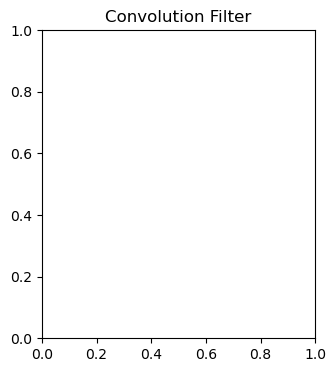

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Vitesse de la lumière en m/s
lightspeed = 299792458.

# Fonction qui génère les coefficients pour le polynôme 2D (x^i * y^j)
def _gen_coeffs(x, y, order):
    ncols = (order + 1) ** 2  # Nombre total de coefficients (ordre+1)^2
    coeffs = np.empty((x.size, ncols), dtype=x.dtype)
    c = 0
    # Remplissage des coefficients pour chaque monome x^i * y^j
    for i in range(order + 1):
        for j in range(order + 1):
            coeffs[:, c] = x**i * y**j  # Calcul du monome pour chaque combinaison (i, j)
            c += 1
    return coeffs

# Fonction qui effectue un ajustement polynomial 2D par moindres carrés
def polyfit2d(x, y, z, order=3):
    # Utilise les coefficients générés par _gen_coeffs pour résoudre le système
    return np.linalg.lstsq(_gen_coeffs(x, y, order), z, rcond=None)[0]

# Fonction qui évalue un polynôme 2D avec les coefficients donnés
def polyval2d(x, y, coeffs):
    order = int(np.sqrt(coeffs.size)) - 1  # Calcul de l'ordre à partir du nombre de coefficients
    z = np.zeros_like(x)  # Initialisation de la sortie (z)
    c = 0
    # Calcul de la valeur du polynôme pour chaque (x, y)
    for i in range(order + 1):
        for j in range(order + 1):
            z += coeffs[c] * x**i * y**j  # Addition de chaque terme du polynôme
            c += 1
    return z

# Matrices P et Q utilisées dans le calcul de la fonction sphéroïdale
P = np.array([
    [8.203343e-2, -3.644705e-1, 6.278660e-1, -5.335581e-1, 2.312756e-1],
    [4.028559e-3, -3.697768e-2, 1.021332e-1, -1.201436e-1, 6.412774e-2]])

Q = np.array([
    [1.0000000e0, 8.212018e-1, 2.078043e-1],
    [1.0000000e0, 9.599102e-1, 2.918724e-1]])

# Fonction qui génère le filtre sphéroïdal 2D
def spheroidal_2d(npix, factor=1.0):
    result = np.zeros((npix, npix), dtype=np.float32)  # Initialisation de la matrice de résultats
    c = np.linspace(-1.0, 1.0, npix)  # Création des coordonnées normalisées
    for y, yc in enumerate(c):
        y_sqrd = yc ** 2  # Carré de y
        for x, xc in enumerate(c):
            r = np.sqrt(xc**2 + y_sqrd) * factor  # Calcul de la distance radiale normalisée
            if r < 0.75:
                poly = 0
                end = 0.75
            elif r <= 1.00:
                poly = 1
                end = 1.00
            else:
                continue  # Si la distance est trop grande, on passe à la prochaine valeur

            sP = P[poly]  # Sélectionne les coefficients appropriés dans P
            sQ = Q[poly]  # Sélectionne les coefficients appropriés dans Q
            nu_sqrd = r**2  # Calcul du carré de la distance radiale
            del_nu_sqrd = nu_sqrd - end**2  # Calcul de la différence par rapport à la borne

            top = sP[0] + sum(sP[i] * del_nu_sqrd**i for i in range(1, 5))  # Calcul du numérateur
            bot = sQ[0] + sum(sQ[i] * del_nu_sqrd**i for i in range(1, 3))  # Calcul du dénominateur

            result[y, x] = (1.0 - nu_sqrd) * (top / bot)  # Calcul final de la valeur du filtre sphéroïdal
    return result

# Fonction pour ajouter du padding à une image (centrée et avec des zéros)
def zero_pad(img, npix):
    # Calcul des dimensions du padding pour centrer l'image
    padding = [(int((npix - s) // 2), int((npix - s + 1) // 2)) for s in img.shape]
    return np.pad(img, padding, mode='constant', constant_values=0)

# Fonction pour générer et appliquer un filtre sphéroïdal anti-aliasing
def spheroidal_aa_filter(npix, support=11, spheroidal_support=111):
    # Génère un filtre sphéroïdal 2D
    cf = spheroidal_2d(spheroidal_support).astype(np.complex128)
    # Applique la transformée de Fourier
    fcf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(cf)))
    
    xc = spheroidal_support // 2
    # Sélectionne un sous-ensemble du filtre
    start = xc - support // 2
    end = 1 + xc + support // 2
    fcf = fcf[start:end, start:end].copy()

    # Effectue un padding sur la transformée de Fourier pour l'adapter à npix
    zfcf = zero_pad(fcf, int(npix))
    # Applique l'inverse de la transformée de Fourier
    ifzfcf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(zfcf)))
    
    return cf, fcf, ifzfcf

def find_max_support(radius, maxw, min_wave):
    """
    Find the maximum support
    """
    # Assumed maximum support
    max_support = 501

    # Work out the spheroidal convolution filter for
    # the maximum support size
#    print("Max support = ", max_support)
    _, _, spheroidal_w = spheroidal_aa_filter(max_support)

    # Compute l, m and n-1 over the area of maximum support
    ex = radius*np.sqrt(2.)
    l, m = np.mgrid[-ex:ex:max_support*1j, -ex:ex:max_support*1j]
    n_1 = np.sqrt(1.0 - l**2 - m ** 2) - 1.0

    # Compute the w term
    w = np.exp(-2.0*1j*np.pi*(maxw/min_wave)*n_1)*spheroidal_w
    fw = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(w)))

    # Want to interpolate across fw. fw is symmetric
    # so take a slice across fw at the halfway point
    fw1d = np.abs(fw[(max_support-1)//2, :])
    # normalise
    fw1d /= np.max(fw1d)
    # Then take half again due to symmetry
    fw1d = fw1d[(max_support-1)//2::]

    ind = np.argsort(fw1d)

    from scipy.interpolate import interp1d

    # TODO(sjperkins)
    # Find a less clunky way to find the maximum support
    interp_fn = interp1d(fw1d[ind], np.arange(fw1d.shape[0])[ind])
    max_support = interp_fn(1./1000)

    print("Local max support =", max_support)

    return max_support

def delta_n_coefficients(l0, m0, radius=1., order=4):
    """
    Returns polynomical coefficients representing the difference
    of coordinate n between a grid of (l,m) values centred
    around (l0, m0) and (l0, m0).
    """

    Np = 100

    l, m = np.mgrid[l0-radius:l0+radius:Np*1j, m0-radius:m0+radius:Np*1j]

    dl = l-l0
    dm = m-m0

    dl = dl.flatten()
    dm = dm.flatten()
    y = np.sqrt(1-(dl+l0)**2-(dm+m0)**2)-np.sqrt(1-l0**2-m0**2)
    coeff = polyfit2d(dl, dm, y, order=order)
    C = coeff.reshape((order+1, order+1))
    Cl = C[0, 1]
    Cm = C[1, 0]
    C[0, 1] = 0
    C[1, 0] = 0

    return Cl, Cm, coeff

def reorganise_convolution_filter(cf, oversampling):
    support = cf.shape[0]//oversampling
    result = np.empty((oversampling, oversampling, support, support),
                      dtype=cf.dtype)

    for i in range(oversampling):
        for j in range(oversampling):
            result[i, j, :, :] = cf[i::oversampling, j::oversampling]

    return result.reshape(cf.shape)

def deapodization(Nx, Ny, filt, K):
#    filter_2D = np.outer(self.filter_taps.astype(float), self.filter_taps.astype(float))
    pad = np.pad(filt, ((Nx*K)//2 - len(filt)//2, (Ny*K)//2-len(filt)//2))
    pad_shift = np.fft.ifftshift(pad)
    pad_im = np.fft.ifft2(pad_shift)
    
    correction = np.real(np.fft.fftshift(pad_im))[(Nx*K)//2 - Nx//2:(Nx*K)//2 + Nx//2,
                                                  (Ny*K)//2 - Ny//2:(Ny*K)//2 + Ny//2]
    
    return correction

def compute_kernels(wplanes, cell_size_arcsec, half_support, max_w, grid_size, oversampling_factor, min_freq, isotropic):
    support = half_support * 2
    radius_radians = np.pi * ((cell_size_arcsec / 3600) * (grid_size / 2)) / 180
    
    min_wavelength = lightspeed / min_freq
    max_w_support = find_max_support(radius_radians, max_w, min_wavelength)
    w_values = np.linspace(0, max_w, wplanes)
    w_supports = np.linspace(support, max(max_w_support, support), wplanes, dtype=np.int64)
    w_supports[w_supports % 2 == 0] += 1

    _, _, poly_coeffs = delta_n_coefficients(0, 0, 3 * radius_radians, order=5)


    wplanes = []
    wplanes_conj = []
    sphere = []

    for i, (w_value, w_support) in enumerate(zip(w_values, w_supports)):
        norm_w_value = w_value / min_wavelength
        
        _, _, spheroidal = spheroidal_aa_filter(w_support, support=w_support)
        
        ex = radius_radians - radius_radians/w_support
        l, m = np.mgrid[-ex:ex:w_support*1j, -ex:ex:w_support*1j]
        n_1 = polyval2d(l, m, poly_coeffs)
        w = np.exp(-2.0*1j*np.pi*norm_w_value*n_1)*np.abs(spheroidal)
        print("w.shape = "+str(w.shape))#9

        
        # zero pad w, adding oversampling
        zw = zero_pad(w, w.shape[0]*oversampling_factor)
        print("Taille avant la FFT:", zw.shape)#9*16  

        #zw /= np.ndarray.sum(zw)#np.linalg.norm(zw)
        zw_conj = np.conj(zw)

        fzw = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(zw)))
        print("Taille après la FFT:", fzw.shape)
        fzw_conj = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(zw_conj)))
        print("Taille après la FFT conjugate:", fzw_conj.shape)
        
        taps = np.linspace(-1.0, 1.0, w.shape[0]*oversampling_factor)
        sinc = np.sinc(taps)
        sinc2D = np.outer(sinc, sinc)
        #fzw *= sinc2D

        fzw = np.require(fzw.astype(np.complex64),requirements=["A", "C"])
        fzw_conj = np.require(fzw_conj.astype(np.complex64),requirements=["A", "C"])

        if isotropic:
            spheroidal = spheroidal[half_support * oversampling_factor:(2 * half_support + 1) * oversampling_factor, half_support * oversampling_factor:(2 * half_support + 1) * oversampling_factor].copy()
            fzw = fzw[half_support * oversampling_factor:(2 * half_support + 1) * oversampling_factor, half_support * oversampling_factor:(2 * half_support + 1) * oversampling_factor].copy()
            fzw_conj = fzw_conj[half_support * oversampling_factor:(2 * half_support + 1) * oversampling_factor, half_support * oversampling_factor:(2 * half_support + 1) * oversampling_factor].copy()
            #spheroidal = spheroidal[0:(half_support + 1) * oversampling_factor, 0:(half_support + 1) * oversampling_factor].copy()
            #fzw = fzw[0:(half_support + 1) * oversampling_factor, 0:(half_support + 1) * oversampling_factor].copy()
            #fzw_conj = fzw_conj[0:(half_support + 1) * oversampling_factor, 0:(half_support + 1) * oversampling_factor].copy()

        wplanes.append(fzw)
        wplanes_conj.append(fzw_conj)
        print("Taille après la iso conjugate:", fzw_conj.shape)

        sphere.append(spheroidal)

    return wplanes, wplanes_conj, sphere, w_supports

# Fonction qui exporte les kernels et supports dans des fichiers CSV
def write_kernels_to_csv(gridding_kernels, degridding_kernels, supports_g, supports_dg, filename, oversampling_factor):
    # Création des noms de fichiers pour les kernels et supports
    dk_filename_r = filename + "_degridding_kernels_real_x" + str(oversampling_factor) + ".csv"
    dk_filename_i = filename + "_degridding_kernels_imag_x" + str(oversampling_factor) + ".csv"
    gk_filename_r = filename + "_gridding_kernels_real_x" + str(oversampling_factor) + ".csv"
    gk_filename_i = filename + "_gridding_kernels_imag_x" + str(oversampling_factor) + ".csv"
    ds_filename = filename + "_degridding_kernel_supports_x" + str(oversampling_factor) + ".csv"
    gs_filename = filename + "_gridding_kernel_supports_x" + str(oversampling_factor) + ".csv"

    #write supports
    f_gs = open(gs_filename, 'w')
    f_dgs = open(ds_filename, 'w')
    gs_writer = csv.writer(f_gs, delimiter = '\n')
    dgs_writer = csv.writer(f_dgs, delimiter = '\n')

    gs_writer.writerow(supports_g)
    dgs_writer.writerow(supports_dg)

    f_gs.close()
    f_dgs.close()

    g_kernels_flat_r = []
    g_kernels_flat_i = []

    dg_kernels_flat_r = []
    dg_kernels_flat_i = []

    #flatten kernels to easily write to files, also separates real and imaginary components into seperate files because this is what SEP expects
    #assumes tuples are (real, imag)
    total_gridding_samples = 0
    total_degridding_samples = 0

    for g_kernel in gridding_kernels:
        flat_g_kernel = np.ndarray.flatten(g_kernel)
        total_gridding_samples += len(flat_g_kernel)
        g_kernels_flat_r += [v.real for v in flat_g_kernel]
        g_kernels_flat_i += [v.imag for v in flat_g_kernel]
        
    print(len(degridding_kernels))

    for dg_kernel in degridding_kernels:
        flat_dg_kernel = np.ndarray.flatten(dg_kernel)
        print(len(flat_dg_kernel))
        print(dg_kernel.shape)
        total_degridding_samples += len(flat_dg_kernel)
        dg_kernels_flat_r += [v.real for v in flat_dg_kernel]
        dg_kernels_flat_i += [v.imag for v in flat_dg_kernel]

    print(str(total_gridding_samples) + " " + str(total_degridding_samples))

    f_gi = open(gk_filename_i, 'w')
    f_gr = open(gk_filename_r, 'w')
    f_dgi = open(dk_filename_i, 'w')
    f_dgr = open(dk_filename_r, 'w')

    ki_writer = csv.writer(f_gi, delimiter = ' ')
    ki_writer.writerow(g_kernels_flat_i)

    kr_writer = csv.writer(f_gr, delimiter = ' ')
    kr_writer.writerow(g_kernels_flat_r)

    dki_writer = csv.writer(f_dgi, delimiter = ' ')
    dki_writer.writerow(dg_kernels_flat_i)

    dkr_writer = csv.writer(f_dgr, delimiter = ' ')
    dkr_writer.writerow(dg_kernels_flat_r)

    f_gi.close()
    f_gr.close()
    f_dgr.close()
    f_dgi.close()

    print(f"Kernels et supports sauvegardés dans les fichiers CSV avec facteur de suréchantillonnage {oversampling_factor}")

# ======== TEST ==========
GRID_SIZE = 512  # Nombre de pixels pour le calcul
NUM_DEGRIDDING_KERNELS = 17  # Nombre de kernel
OVERSAMPLING_FACTOR = 16  # Facteur de suréchantillonnage
FOV_DEGREES = 1
cell_size_arcsec = (FOV_DEGREES * np.pi) / (180.0 * GRID_SIZE)
print("cell_size_arcsec"+str(cell_size_arcsec))
baseline_max = 100
frequency_hz = 29979
SPEED_OF_LIGHT = 299792458.
max_w = baseline_max*frequency_hz/SPEED_OF_LIGHT;
k=100
half_support =int( (GRID_SIZE/2 -1)/k)

wplanes, wplanes_conj, sphere, w_supports = compute_kernels(NUM_DEGRIDDING_KERNELS, cell_size_arcsec, half_support, max_w, GRID_SIZE, OVERSAMPLING_FACTOR, frequency_hz, True)
w_supports = [v // 2 for v in w_supports]
print("taille w_supports:"+str(len(w_supports)))


# Nom du fichier pour l'exportation
filename = "code/config/wproj_manualconj"

# Exportation des kernels et supports en CSV
write_kernels_to_csv(wplanes, wplanes_conj, w_supports, w_supports, filename, OVERSAMPLING_FACTOR)

# Visualisation des résultats (filtre, transformée de Fourier, et inverse FFT)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Convolution Filter')
plt.imshow(cf.real)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('Fourier Transform')
plt.imshow(np.abs(fcf))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Padded Inverse FT')
plt.imshow(np.abs(ifzfcf))
plt.colorbar()

plt.show()

# merci chatgpt

#### Step 4: run the dataflow executable

In [1]:
import os
import subprocess

dataflow_directory = "code"
EXECUTABLE = os.path.join(dataflow_directory, "STD_DEGRID")

if not os.path.exists(EXECUTABLE):
    print(f"Erreur : L'exécutable {EXECUTABLE} n'existe pas.")
    exit(1)

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run([EXECUTABLE, "200000", "512", "50"], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")

Le répertoire actuel est /home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator. Changement vers code...
Lancement : ./STD_DEGRID
Nombre impair de valeurs détecté, suppression du dernier élément.
UPDATE >>> Image loaded from image.csv
Grille d'entrée 0: -0.002857 + 0.003288i
Grille d'entrée 1: 0.004019 + -0.011010i
Grille d'entrée 2: 0.003381 + 0.017395i
Grille d'entrée 3: 0.007835 + 0.005145i
Grille d'entrée 4: -0.009355 + 0.010198i
UPDATE >>> Loading degridding kernel support file from config/wproj_manualconj_degridding_kernel_supports_x16.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is 39168...

UPDATE >>> Loading kernel files file from config/wproj_manualconj_degridding_kernels_real_x16.csv real and config/wproj_manualconj_degridding_kernels_imag_x16.csv imaginary...

kernel_supports 0: 2 + 0i
kernel_supports 1: 2 + 2304i
kernel_supports 2: 2 + 4608i
kernel_supports 3: 2 + 6912i
kernel_supports 4: 2 + 9216i
kernels 0: 441.835114 + -1359

L'étape suivante n'est pas necessaire, c'est juste pour vérifier que j'ai pas merdé à converir *.fits en *.csv

2


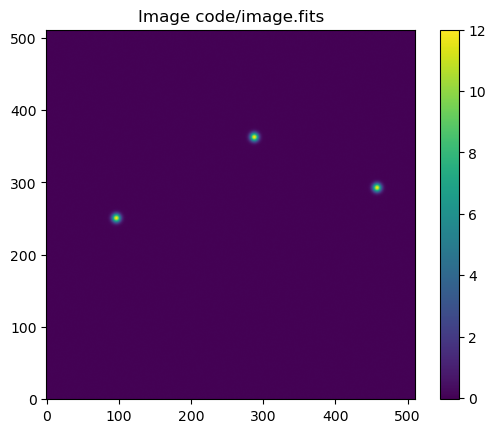

In [2]:
import numpy
import sys
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt

def write_nparr_to_fits(data, filename):
    hdu = fits.PrimaryHDU(data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)
    hdulist.close()

def display_fits_image(fits_file):
    # Charger les données du fichier FITS
    hdulist = fits.open(fits_file)
    data = hdulist[0].data  # Les données de l'image sont dans la première extension
    print(data.ndim)
    hdulist.close()

    # Affichage de l'image avec matplotlib
    plt.imshow(data, cmap='viridis', origin='lower')
    plt.colorbar()  # Ajoute une barre de couleur pour l'échelle des intensités
    plt.title(f"Image {fits_file}")
    plt.show()

IMAGE = "code/image.csv"
FITS = "code/image.fits"
delimiter = ","

result = numpy.genfromtxt(IMAGE, delimiter=delimiter)[:,:-1]  # Ignorer la dernière colonne si nécessaire result = numpy.flip(result)

write_nparr_to_fits(result, FITS)
display_fits_image(FITS)

#### Step 5: Visualize the generated visibilities

Min u : -0.0309, Max u : 0.040083
Min v : -0.031172, Max v : 0.033638
Min réel : -0.00325, Max réel : 0.01071
Min imaginaire : 0.00756, Max imaginaire : 0.014196
Maximum d'amplitude : 0.01778287142167991


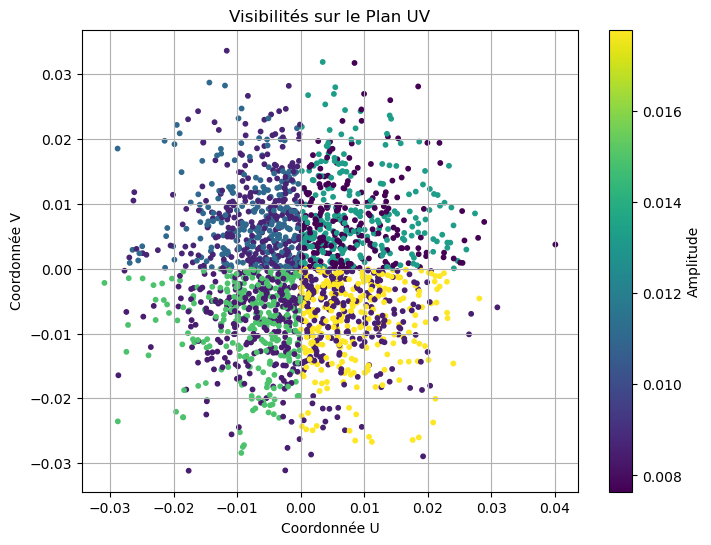

In [22]:
from plot_vis import plot_visibilities

plot_visibilities("code/vis.csv")

#### Step ++: compute psf

case PSF_GRID_SIZE > GRID_SIZE:
- The PSF will be truncated by our pipelines: only a central region of the PSF is copied to the image grid.
case PSF_GRID_SIZE < GRID_SIZE:
- The PSF will be placed at the center of the image grid, and values outside this area will remain zero.

| **PSF Parameter**     | **Impact on Reconstructed Image**                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------------|
| **Sigma (Width)**     | - Small sigma: Concentrated PSF, higher resolution but may amplify noise.                          |
|                       | - Large sigma: Spread PSF, reduces noise but also decreases resolution.                            |
| **Grid Size**         | - Small grid: PSF doesn't capture enough of the instrument's response.                            |
|                       | - Large grid: Can add artifacts or be unusable in convolution algorithms.                          |
| **PSF Shape**         | - Gaussian is commonly used, but more complex PSFs (Airy, Moffat, etc.) may better represent real optics. |
| **Normalization**     | - Normalizing to unity ensures energy conservation in convolution.                                |
|                       | - Incorrect normalization may introduce biases into the reconstructed image.                      |
| **Truncation**        | - Sharp truncation at the edges of the PSF grid may introduce artifacts in the reconstructed image. |
| **Symmetry**          | - Asymmetric PSF can cause distortions in the reconstructed image.                                |


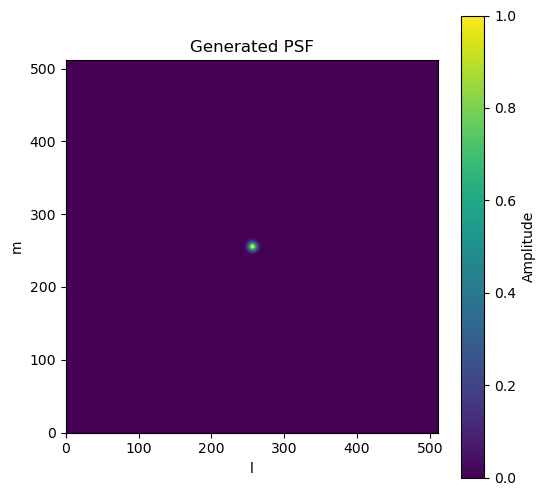

PSF exported to code_dft/data/input/psf.csv


In [4]:
from psf import generate_psf
GRID_SIZE = 512
generate_psf(GRID_SIZE,4,"code_dft/data/input/psf.csv")


#### Step ++: Running GIP - DFT

In [41]:
import os
import subprocess

dataflow_directory = "code_dft"
EXECUTABLE = os.path.join(dataflow_directory, "SEP_Pipeline")

if not os.path.exists(EXECUTABLE):
    print(f"Erreur : L'exécutable {EXECUTABLE} n'existe pas.")
    exit(1)

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run([EXECUTABLE, "200000", "512", "50"], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")

Lancement : code_dft/SEP_Pipeline

Erreur :
PSF: : No such file or directory



#### Step ++: csv to fits

In [13]:
import os
import numpy as np
from astropy.io import fits


def write_nparr_to_fits(data, filename):
    hdu = fits.PrimaryHDU(data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)
    hdulist.close()

def convert_csv_to_fits(csv_file, fits_file, delimiter):
    try:
        # Charge les données à partir du fichier CSV
        result = np.genfromtxt(csv_file, delimiter=delimiter)

        # Vérifie si le tableau a au moins une ligne
        if result.size == 0:
            print(f"Warning: {csv_file} is empty.")
            return

        # S'assurer que le tableau a plus d'une colonne
        if result.shape[1] <= 1:
            print(f"Warning: {csv_file} does not have enough columns.")
            return

        result = np.flip(result)
        write_nparr_to_fits(result, fits_file)
        #print(f"Converted {csv_file} to {fits_file}")
    except Exception as e:
        print(f"Error converting {csv_file}: {e}")


def convert_all_csv_in_directory(input_dir, output_dir, delimiter):
    # Vérifie si le répertoire de sortie existe, sinon le crée
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Parcours tous les fichiers dans le répertoire d'entrée
    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            csv_file_path = os.path.join(input_dir, filename)
            fits_file_path = os.path.join(output_dir, filename.replace('.csv', '.fits'))
            convert_csv_to_fits(csv_file_path, fits_file_path, delimiter)



input_directory = "code_dft/data/output/tune/"
output_directory = "code_dft/data/fits/"
delimiter = ","
convert_all_csv_in_directory(input_directory, output_directory, delimiter)

#### Step++: visualizing the reconstructed image

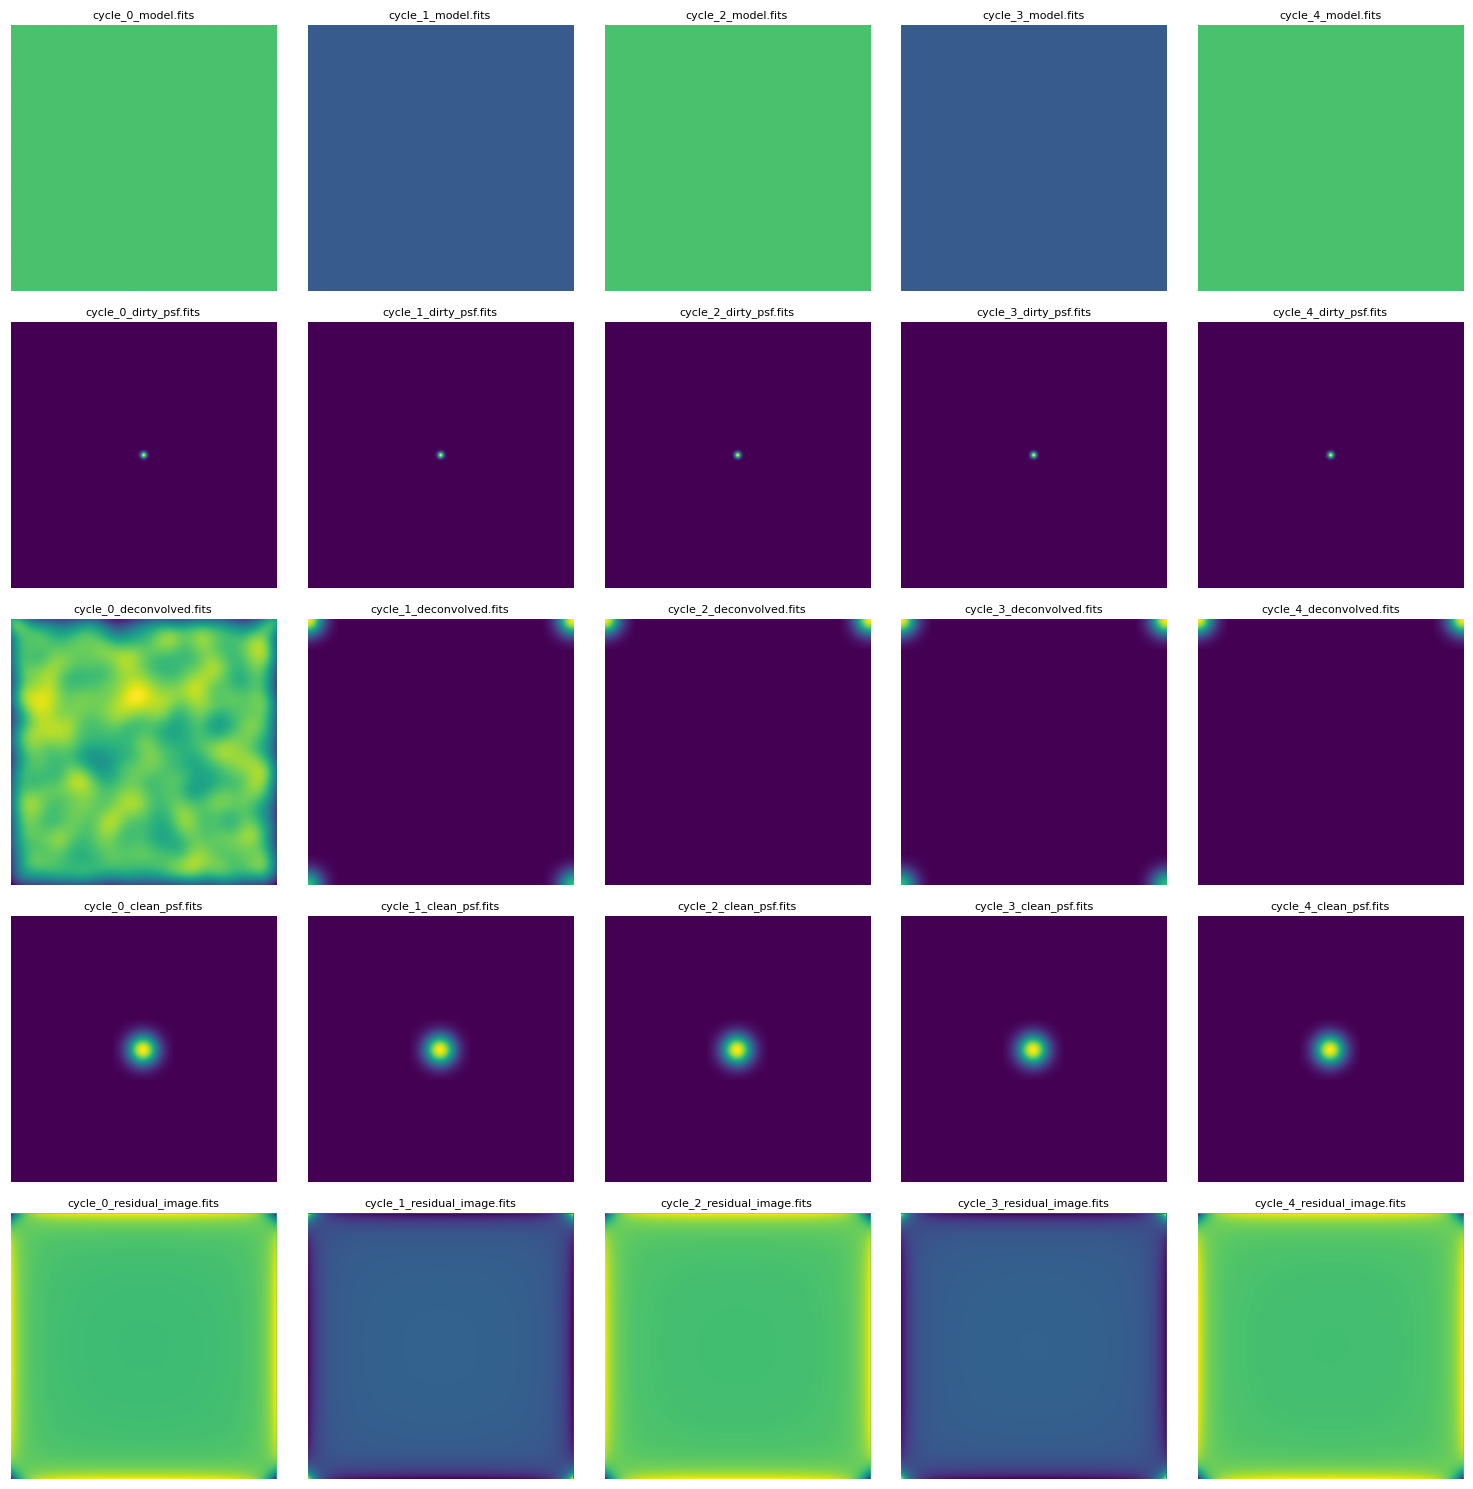

In [14]:
import os
import glob
from collections import deque
from astropy.io import fits
import matplotlib.pyplot as plt

NUM_MAJOR_CYCLE = 5

# Fonction pour afficher une image FITS dans une cellule
def display_fits_images(ax, fits_file):
    hdulist = fits.open(fits_file)
    data = hdulist[0].data
    hdulist.close()

    if data is not None:
        ax.imshow(data, cmap='viridis', origin='lower')
        ax.set_title(os.path.basename(fits_file), fontsize=8)
        ax.axis('off')


def display_images_by_type(base_dir, types):
    fig, axs = plt.subplots(len(types), NUM_MAJOR_CYCLE, figsize=(15, 3 * len(types)))  # NUM_MAJOR_CYCLE colonnes, 1 ligne par type
    
    for row, image_type in enumerate(types):
        # Trouver et trier les fichiers par cycle
        files = sorted(glob.glob(f"{base_dir}/*_{image_type}.fits"))
        
        for col in range(NUM_MAJOR_CYCLE):
            if col < len(files):
                display_fits_images(axs[row, col], files[col])
            else:
                axs[row, col].axis('off')  

    plt.tight_layout()
    plt.show()

base_dir = 'code_dft/data/fits'
types = ['model', 'dirty_psf', 'deconvolved', 'clean_psf', 'residual_image']

display_images_by_type(base_dir, types)

#### Step++: check quality

On est déjà dans le répertoire code_dft.


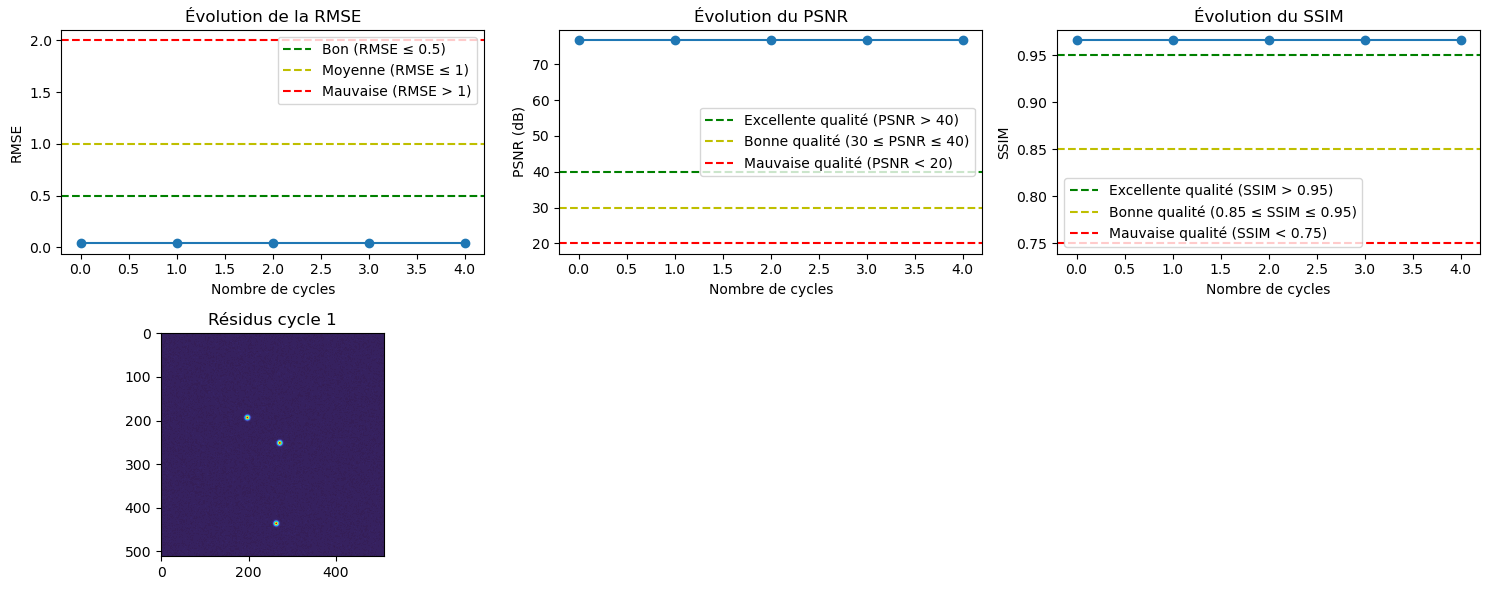

In [37]:
from astropy.io import fits
from skimage.metrics import structural_similarity as ssim
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from math import log10, sqrt


# 🔎 Fonction pour trier les fichiers par type dans un tableau ordonné
def get_sorted_files(base_dir, types):
    sorted_files = []
    for t in types:
        files = sorted(glob.glob(f"{base_dir}/*_{t}.fits"))[:5]
        sorted_files.append(files)
    return sorted_files

# 📏 Calcul de la RMSE
def calculate_rmse(reference_image, deconvolved_image):
    # Charger les données des deux images FITS
    reference_data = reference_image[0].data
    deconvolved_data = deconvolved_image[0].data
    
    
    # Vérifier que les images ont la même taille
    if reference_data.shape != deconvolved_data.shape:
        # Retirer la dernière colonne de l'image déconvulée pour la mettre à la même taille que la référence
        deconvolved_data = deconvolved_data[:, 1:]
        
    # Calculer la RMSE
    rmse = np.sqrt(np.mean((reference_data - deconvolved_data) ** 2))
    
    return rmse

# 📈 Calcul du PSNR
def calculate_psnr(reference_image, deconvolved_image):
    # Charger les données des deux images FITS
    reference_data = reference_image[0].data
    deconvolved_data = deconvolved_image[0].data
    
    
    # Vérifier que les images ont la même taille
    if reference_data.shape != deconvolved_data.shape:
        # Retirer la dernière colonne de l'image déconvulée pour la mettre à la même taille que la référence
        deconvolved_data = deconvolved_data[:, 1:]
        
    mse = np.mean((reference_data - deconvolved_data) ** 2)
    if mse == 0:
        return 100  # Pas d'erreur, les images sont identiques
    max_pixel = 255.0
    return 10 * log10((max_pixel ** 2) / mse)

# 🖼 Calcul du SSIM
def calculate_ssim(reference_image, deconvolved_image):
    # Charger les données des deux images FITS
    reference_data = reference_image[0].data
    deconvolved_data = deconvolved_image[0].data
    
    
    # Vérifier que les images ont la même taille
    if reference_data.shape != deconvolved_data.shape:
        # Retirer la dernière colonne de l'image déconvulée pour la mettre à la même taille que la référence
        deconvolved_data = deconvolved_data[:, 1:]
        
    return ssim(reference_data, deconvolved_data,data_range=reference_data.max() - reference_data.min())


# Chemin vers le dossier du degridder
dataflow_directory = "code_dft"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")
    
reference = fits.open("../code/radioastro.fits")
sorted_files = get_sorted_files("data/fits", ["deconvolved"])  # Fichiers déconvulés
rmse_values = []
psnr_values = []
ssim_values = []

num_cycle = []
residuals = []

# Calcul de la RMSE pour chaque image déconvulée
for i, deconvolved_file in enumerate(sorted_files[0]):  
    num_cycle.append(i)
    deconvolved_image = fits.open(deconvolved_file)
    rmse_value = calculate_rmse(reference, deconvolved_image)
    rmse_values.append(rmse_value)
    psnr_value = calculate_psnr(reference,deconvolved_image)
    psnr_values.append(psnr_value)
    ssim_value = calculate_ssim(reference,deconvolved_image)
    ssim_values.append(ssim_value)
    residual = reference[0].data - deconvolved_image[0].data[:, 1:]
    residuals.append(residual)

    
    #print(f"RMSE pour l'image déconvulée {deconvolved_file}: {rmse_value}")

fig, axes = plt.subplots(2, 3, figsize=(15, 6))

# Graphique RMSE
axes[0, 0].plot(num_cycle, rmse_values, marker='o', linestyle='-', color='tab:blue')
# Définir les zones de qualité pour RMSE
axes[0, 0].axhline(y=0.5, color='g', linestyle='--', label='Bon (RMSE ≤ 0.5)')
axes[0, 0].axhline(y=1, color='y', linestyle='--', label='Moyenne (RMSE ≤ 1)')
axes[0, 0].axhline(y=2, color='r', linestyle='--', label='Mauvaise (RMSE > 1)')
axes[0, 0].set_xlabel('Nombre de cycles')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Évolution de la RMSE')
axes[0, 0].legend()

# Graphique PSNR
axes[0, 1].plot(num_cycle, psnr_values, marker='o', linestyle='-', color='tab:blue')
# Définir les zones de qualité pour PSNR
axes[0, 1].axhline(y=40, color='g', linestyle='--', label='Excellente qualité (PSNR > 40)')
axes[0, 1].axhline(y=30, color='y', linestyle='--', label='Bonne qualité (30 ≤ PSNR ≤ 40)')
axes[0, 1].axhline(y=20, color='r', linestyle='--', label='Mauvaise qualité (PSNR < 20)')
axes[0, 1].set_xlabel('Nombre de cycles')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('Évolution du PSNR')
axes[0, 1].legend()

# Graphique SSIM
axes[0, 2].plot(num_cycle, ssim_values, marker='o', linestyle='-', color='tab:blue')
# Définir les zones de qualité pour SSIM
axes[0, 2].axhline(y=0.95, color='g', linestyle='--', label='Excellente qualité (SSIM > 0.95)')
axes[0, 2].axhline(y=0.85, color='y', linestyle='--', label='Bonne qualité (0.85 ≤ SSIM ≤ 0.95)')
axes[0, 2].axhline(y=0.75, color='r', linestyle='--', label='Mauvaise qualité (SSIM < 0.75)')
axes[0, 2].set_xlabel('Nombre de cycles')
axes[0, 2].set_ylabel('SSIM')
axes[0, 2].set_title('Évolution du SSIM')
axes[0, 2].legend()

# Affichage des résidus
axes[1, 0].imshow(residuals[0], cmap='turbo')
axes[1, 0].set_title("Résidus cycle 1")

# Suppression des axes vides (si nécessaire)
axes[1, 1].axis('off')
axes[1, 2].axis('off')


plt.tight_layout()
plt.show()


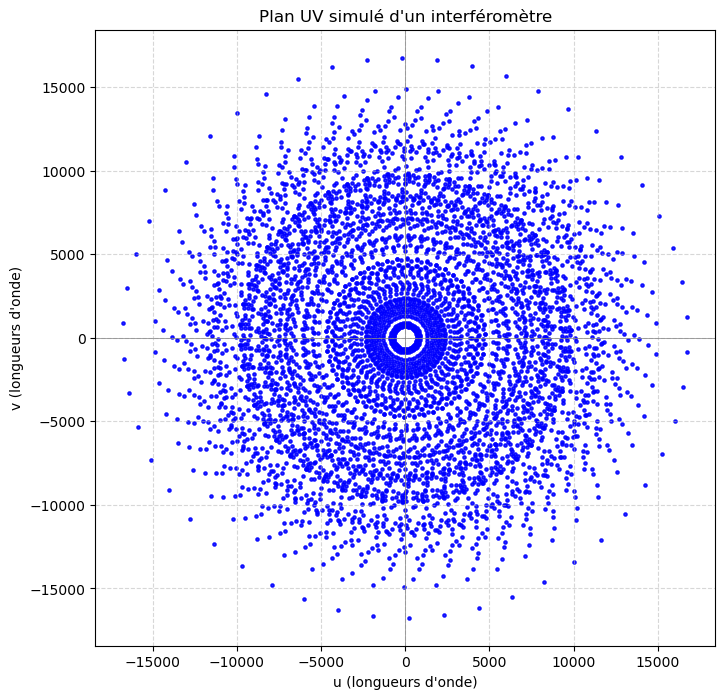

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de l'interféromètre
num_baselines = 15  # Nombre de paires d'antennes
num_timesteps = 50  # Nombre d'instants d'observation (simule la rotation de la Terre)
wavelength = 0.21   # Longueur d'onde en mètres (ex: 1.4 GHz pour l'hydrogène neutre)

# Génération des coordonnées des antennes (aléatoire dans un réseau de 3 km x 3 km)
antennas_x = np.random.uniform(-1500, 1500, num_baselines)
antennas_y = np.random.uniform(-1500, 1500, num_baselines)

# Calcul des bases
u_coords = []
v_coords = []

for t in range(num_timesteps):
    # Angle de rotation (simule la rotation de la Terre)
    theta = (t / num_timesteps) * 2 * np.pi

    for i in range(num_baselines):
        for j in range(i + 1, num_baselines):
            # Différence entre antennes
            bx = antennas_x[j] - antennas_x[i]
            by = antennas_y[j] - antennas_y[i]

            # Projection sur le plan UV
            u = (bx * np.cos(theta) + by * np.sin(theta)) / wavelength
            v = (-bx * np.sin(theta) + by * np.cos(theta)) / wavelength

            # Ajouter les points et leur symétrie conjugée
            u_coords.extend([u, -u])
            v_coords.extend([v, -v])

# Tracé du diagramme UV
plt.figure(figsize=(8, 8))
plt.scatter(u_coords, v_coords, s=5, color='blue', alpha=0.6)
plt.xlabel("u (longueurs d'onde)")
plt.ylabel("v (longueurs d'onde)")
plt.title("Plan UV simulé d'un interféromètre")
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
